In [1]:
# Short-term dynamics of Excitation-Inhibition Balance in Hippocampal CA3-CA1 circuit
# Aditya Asopa, Upinder Singh Bhalla, NCBS
# Figure 2
# September 2024
# Imports -----------------------------------------------------------------------------------------------
from   pathlib      import Path
import importlib

import numpy                as np
import matplotlib           as mpl
import matplotlib.pyplot    as plt
import seaborn              as sns
import pandas               as pd

from scipy.stats   import kruskal, wilcoxon, mannwhitneyu, ranksums
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
import statsmodels.formula.api as smf

# from eidynamics     import utils, data_quality_checks, ephys_classes, plot_tools, expt_to_dataframe
# from eidynamics     import pattern_index
# from eidynamics     import abf_to_data
from eidynamics.fit_PSC     import find_sweep_expected
# from Findsim        import tab_presyn_patterns_LR_43
# import parse_data
from eidynamics     import utils, plot_tools
import all_cells
import plotFig2
import stat_annotate

# sns.set_context('paper')
# sns.set_context('paper')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

# make a colour map viridis
viridis = mpl.colormaps["viridis"]
flare   = mpl.colormaps["flare"]
crest   = mpl.colormaps["crest"]
magma   = mpl.colormaps["magma"]
edge    = mpl.colormaps['edge']

color_E = "flare"
color_I = "crest"
color_freq = {1:magma(0.05), 5:magma(0.1), 10:magma(0.2), 20:magma(.4), 30:magma(.5), 40:magma(.6), 50:magma(.7), 100:magma(.9)}
color_squares = color_squares = {1:viridis(0.2), 5:viridis(.4), 7:viridis(.6), 15:viridis(.8), 20:viridis(1.0)}
color_EI = {-70:flare(0), 0:crest(0)}
colors_EI = {-70:flare, 0:crest}

Fs = 2e4
%matplotlib widget
freq_sweep_pulses = np.arange(9)

>> Working on:  C:\Users\adity\OneDrive\NCBS


In [2]:
figure_raw_material_location = Path(r"paper_figure_matter\\")
paper_figure_export_location = Path(r"paper_figures\\Figure2v4\\")
data_path_FS                 = Path(r"parsed_data\\FreqSweep\\")
data_path_grid               = Path(r"parsed_data\\Grid\\")
data_path_analysed           = Path(r"parsed_data\\second_order\\")
raw_data_path_cellwise       = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data\Screened_cells\\")

# Load Data

In [3]:
# September 2024
# short data path that contains the kernel fit data for FreqSweep protocol, also contains the field p2p data. latest and checked. Use this for all freqsweep measurements.
# Contains screening parameters also.
# 18Sep24
CC_FS_shortdf_withkernelfit_datapath = data_path_FS / "all_cells_FreqSweep_CC_kernelfit_response_measurements.h5"
cc_FS_shortdf = pd.read_hdf(CC_FS_shortdf_withkernelfit_datapath, key='data')
print(cc_FS_shortdf.shape)

VC_FS_shortdf_withkernelfit_datapath = data_path_FS / "all_cells_FreqSweep_VC_kernelfit_response_measurements.h5"
vc_FS_shortdf = pd.read_hdf(VC_FS_shortdf_withkernelfit_datapath, key='data')
print(vc_FS_shortdf.shape)

# short data path for all protocols.
# Does not contain kernel fit measurements and does not contain screening parameters. Only use for other protocols.
# 18Sep24
dfshortpath     = data_path_analysed / "all_cells_allprotocols_with_fpr_values.h5"
xc_all_shortdf  = pd.read_hdf(dfshortpath, key='data')
print(xc_all_shortdf.shape)

# Load the long dataset
cc_FS_datapath =  data_path_FS / "all_cells_FreqSweep_CC_long.h5" 
vc_FS_datapath =  data_path_FS / "all_cells_FreqSweep_VC_long.h5"

(4971, 163)
(4113, 163)
(16870, 63)


In [4]:
# CC data screening based on dataflag_fields
cc_FS_shortdf_slice = cc_FS_shortdf[
            (cc_FS_shortdf['location'] == 'CA1') &
            (cc_FS_shortdf['numSq'].isin([1,5,15])) &
            (cc_FS_shortdf['stimFreq'].isin([20,30,40,50])) &
            (cc_FS_shortdf['condition'] == 'Control') &
            (cc_FS_shortdf['ch0_response']==1) &
            (cc_FS_shortdf['IR'] >50) & (cc_FS_shortdf['IR'] < 300) &
            (cc_FS_shortdf['tau'] < 40) & 
            (cc_FS_shortdf['intensity'] == 100) &
            (cc_FS_shortdf['pulseWidth'] == 2) &
            (cc_FS_shortdf['spike_in_baseline_period'] == 0) &
            (cc_FS_shortdf['ac_noise_power_in_ch0'] < 40) 
            # (cc_FS_shortdf['valley_0'].notnull())
        ]
print(cc_FS_shortdf.shape, '--screened-->', cc_FS_shortdf_slice.shape)
screened_cc_trialIDs = cc_FS_shortdf_slice['trialID'].unique()

print(f"Unique cells in screened data: { cc_FS_shortdf_slice['cellID'].nunique()}")
print(f"Unique sweeps in screened data: {cc_FS_shortdf_slice['trialID'].nunique()}")

# save trial IDs as a numpy array text file, all trialID are strings
np.savetxt(data_path_FS / "Figure2_screened_trialIDs_CC_FS.txt", screened_cc_trialIDs, fmt='%s')

(4971, 163) --screened--> (2201, 163)
Unique cells in screened data: 16
Unique sweeps in screened data: 2201


In [5]:
# VC data screening based on dataflag_fields
vc_FS_shortdf_slice = vc_FS_shortdf[
            (vc_FS_shortdf['location'] == 'CA1') &
            (vc_FS_shortdf['numSq'].isin([1,5,15])) &
            (vc_FS_shortdf['stimFreq'].isin([20,30,40,50])) &
            (vc_FS_shortdf['condition'] == 'Control') &
            (vc_FS_shortdf['ch0_response']==1) &
            (vc_FS_shortdf['intensity'] == 100) &
            (vc_FS_shortdf['pulseWidth'] == 2) &
            (vc_FS_shortdf['probePulseStart']==0.2) &
            (vc_FS_shortdf['IR'] >50) & (vc_FS_shortdf['IR'] < 300) &
            (vc_FS_shortdf['tau'] < 40) & 
            (vc_FS_shortdf['ac_noise_power_in_ch0'] < 40)&
            (vc_FS_shortdf['valley_0'].notnull())
        ]
print(vc_FS_shortdf.shape, '--screened-->', vc_FS_shortdf_slice.shape)
screened_vc_trialIDs = vc_FS_shortdf_slice['trialID'].unique()

print(f"Unique cells in screened data: { vc_FS_shortdf_slice['cellID'].nunique()}")
print(f"Unique sweeps in screened data: {vc_FS_shortdf_slice['trialID'].nunique()}")

# save the screened trialIDs
# save trial IDs as a numpy array text file, all trialID are strings
np.savetxt(data_path_FS / "Figure2_screened_trialIDs_VC_FS.txt", screened_vc_trialIDs, fmt='%s')

(4113, 163) --screened--> (931, 163)
Unique cells in screened data: 6
Unique sweeps in screened data: 931


In [6]:
# combine short dataframes slice and delete the original ones
xc_FS_shortdf_slice = pd.concat([cc_FS_shortdf_slice, vc_FS_shortdf_slice], axis=0)
del cc_FS_shortdf, vc_FS_shortdf
del cc_FS_shortdf_slice, vc_FS_shortdf_slice

In [7]:
### Load the Longform data and keep the screened trials only to save space
# load the data
# cc_FS_datapath =  data_path_FS / "all_cells_FreqSweep_CC_long.h5"
# cc_FS_longdf = pd.read_hdf(cc_FS_datapath, key='data')

# cc_FS_longdf_slice = cc_FS_longdf[ cc_FS_longdf['trialID'].isin(screened_cc_trialIDs) ]
# print('CC: ', cc_FS_longdf.shape, '--screened-->', cc_FS_longdf_slice.shape)
# del cc_FS_longdf

# load the data
vc_FS_datapath =  data_path_FS / "all_cells_FreqSweep_VC_long.h5"
vc_FS_longdf = pd.read_hdf(vc_FS_datapath, key='data')

vc_FS_longdf_slice = vc_FS_longdf[ vc_FS_longdf['trialID'].isin(screened_vc_trialIDs) ]
print('VC: ', vc_FS_longdf.shape, '--screened-->', vc_FS_longdf_slice.shape)
del vc_FS_longdf

# xc_FS_longdf_slice = pd.concat([cc_FS_longdf_slice, vc_FS_longdf_slice])
# del cc_FS_longdf_slice, vc_FS_longdf_slice

VC:  (4407, 80073) --screened--> (931, 80073)


# Setup figure2

data shape: (2047, 163)


c:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\eidynamics\plot_tools.py:602: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  Fig.subplots_adjust(hspace=0.5, wspace=0.5)
C:\Users\adity\AppData\Local\Temp\ipykernel_65196\1033549991.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp['numspikes'] = dftemp[[f'spike_{i}' for i in range(9)]].sum(axis=1)
c:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\eidynamics\plot_tools.py:602: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  Fig.subplots_adjust(hspace=0.5, wspace=0.5)


data shape: (154, 164)
data shape: (529, 163)


c:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\eidynamics\plot_tools.py:602: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  Fig.subplots_adjust(hspace=0.5, wspace=0.5)


data shape: (402, 163)


c:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\eidynamics\plot_tools.py:602: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  Fig.subplots_adjust(hspace=0.5, wspace=0.5)


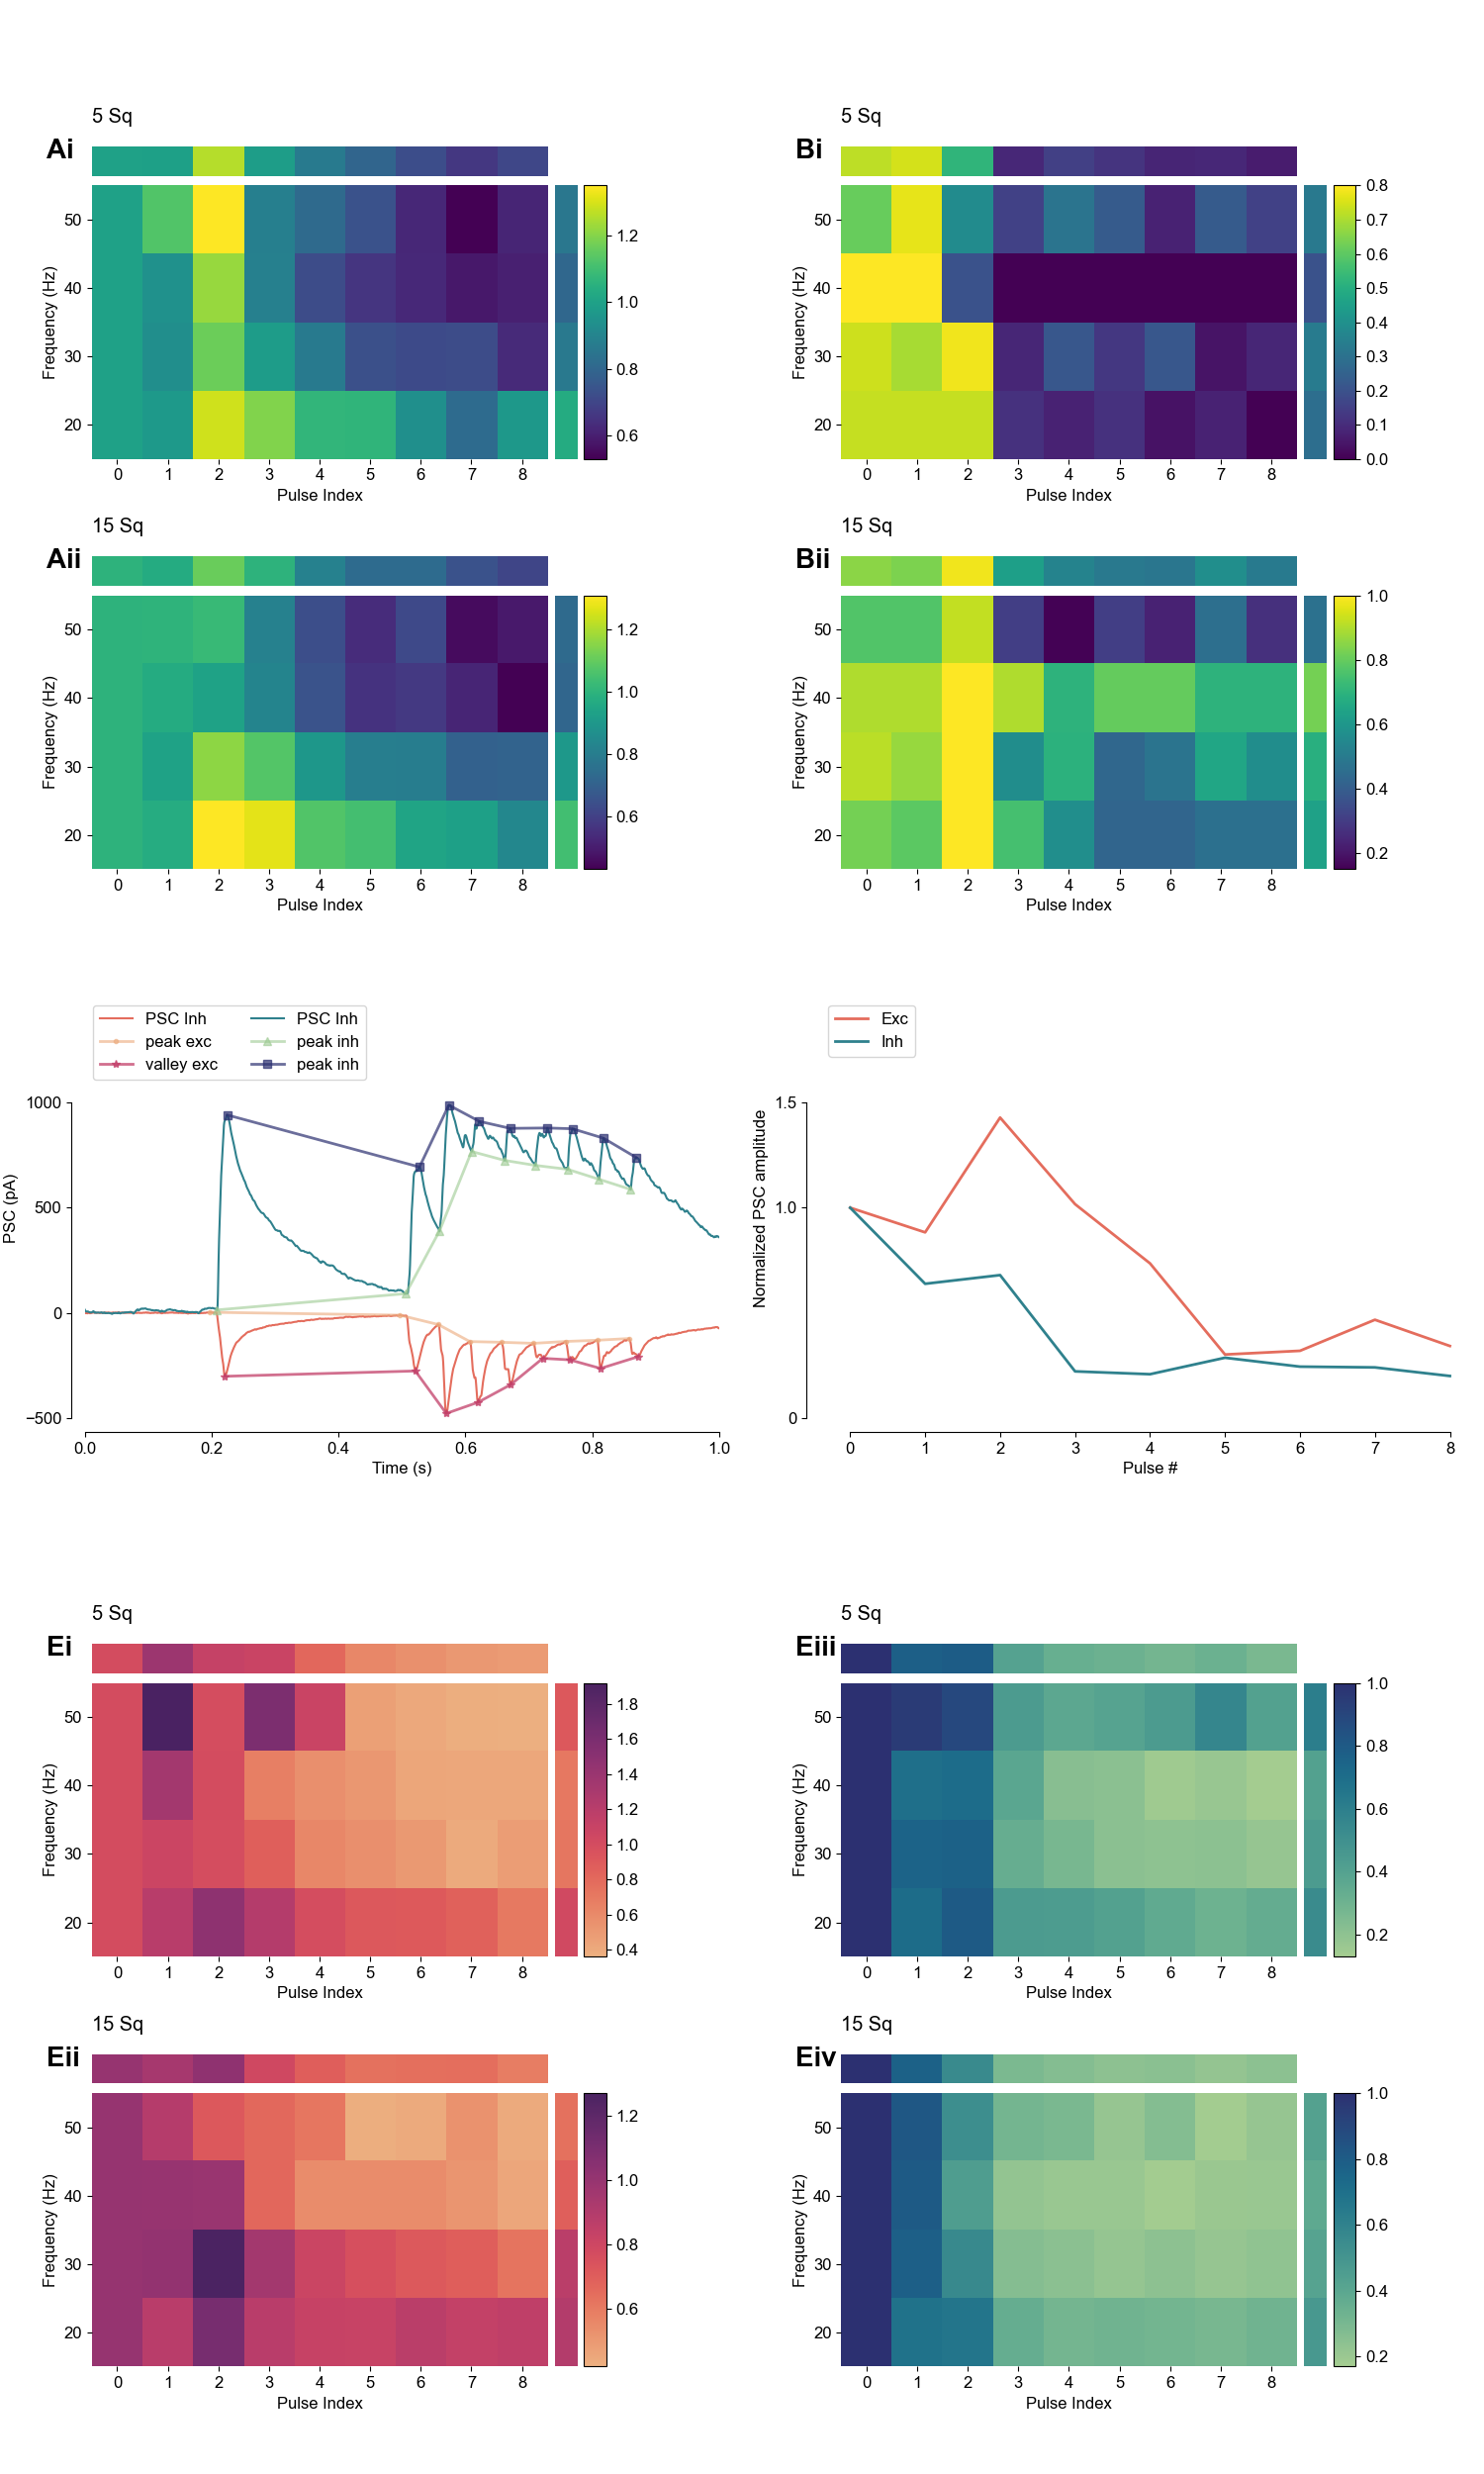

In [8]:
# Setup the figure
w,h = 15,25   
fig = plt.figure(layout='constrained', figsize=(w,h))

[Fig2Top, Fig2Mid, Fig2Bottom] = fig.subfigures(3,1, wspace=0.03, hspace=0.02, height_ratios=[2, 1, 2])

[subfigsA, subfigsB] = Fig2Top.subfigures(1,2)
[subfigsC, subfigsD] = Fig2Mid.subfigures(1,2)
[subfigsE1, subfigsE2] = Fig2Bottom.subfigures(1,2)

# [ax2Ai, ax2Aii] = subfigsA.subplots(2,1)
# [ax2Bi, ax2Bii] = subfigsB.subplots(2,1)
ax2C = subfigsC.subplots(1,1)
ax2D = subfigsD.subplots(1,1)
# [[ax2Ei, ax2Eii],[ax2Eiii, ax2Eiv]] = Fig2Bottom.subplots(2,2)
importlib.reload(plot_tools)

# get location of subfigsA in the main figure
# subfigsA_pos = subfigsA.get_position()
## -----------------------------------------------------------------------------------------------
# Fig2A: CC heatmap of normPSC
importlib.reload(plot_tools)
dftemp = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['clampMode']=='CC')]
f,a = plot_tools.plot_response_heatmaps(dftemp[dftemp['AP']==0], feature='normPSC_', Fig=subfigsA, figlabels=['Ai','Aii'], clampMode='CC', annot=False)

# spike likelihood heatmap
dftemp = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['clampMode']=='CC')]
dftemp['numspikes'] = dftemp[[f'spike_{i}' for i in range(9)]].sum(axis=1)
dftemp= dftemp[(dftemp['AP']==1) ]
f,a = plot_tools.plot_response_heatmaps(dftemp, feature='spike_', Fig=subfigsB, figlabels=['Bi','Bii'], clampMode='CC', annot=False, )

## -----------------------------------------------------------------------------------------------
# Fig2C: Upi's fitting of the kernel for both E and I
cell = 7492
pattern = 52
trial = 0 # or 1
exc_sweep = vc_FS_longdf_slice[(vc_FS_longdf_slice['cellID']==cell) & (vc_FS_longdf_slice['patternList']==pattern) & (vc_FS_longdf_slice['clampPotential']==-70)& (vc_FS_longdf_slice['stimFreq']==20)]
inh_sweep = vc_FS_longdf_slice[(vc_FS_longdf_slice['cellID']==cell) & (vc_FS_longdf_slice['patternList']==pattern) & (vc_FS_longdf_slice['clampPotential']==0)  & (vc_FS_longdf_slice['stimFreq']==20)]

row = exc_sweep.iloc[0, :]
_,_, npv_exc, _ = exc_results = plotFig2.deconv(row[49:80049], row['stimFreq'], row['probePulseStart'], row['pulseTrainStart'], None, noprobepulse=(row['probePulseStart']==0.5))
valley_times = npv_exc[0]
peak_times = npv_exc[3]
ax2C.plot(np.linspace(0,1,20000), row[49:20049], color='#e46d5dff', label='PSC Inh')
ax2C.plot(npv_exc[0], npv_exc[1], color='#ecab7d9d', marker=".", linewidth=2, label='peak exc')
ax2C.plot(npv_exc[2], npv_exc[3], color='#c23f69bf', marker="*", linewidth=2, label='valley exc')

row = inh_sweep.iloc[0, :]
_,_, npv_inh, _ = inh_results = plotFig2.deconv(row[49:80049], row['stimFreq'], row['probePulseStart'], row['pulseTrainStart'], None, noprobepulse=(row['probePulseStart']==0.5))
valley_times = npv_inh[0]
peak_times = npv_inh[3]
ax2C.plot(np.linspace(0,1,20000), row[49:20049], color='#2f818dff', label='PSC Inh')
ax2C.plot(npv_inh[0], npv_inh[1], color='#9dca929a', marker="^", linewidth=2, label='peak inh')
ax2C.plot(npv_inh[2], npv_inh[3], color='#2c3071b3', marker="s", linewidth=2, label='peak inh')

#cosmetics
ax2C.set_xlabel('Time (s)')
ax2C.set_ylabel('PSC (pA)')
ax2C.set_xlim([0,1])
ax2C.set_ylim([-500,1500])
ax2C.set_xticks(np.linspace(0,1.0,6, endpoint=True))
ax2C.set_yticks([-500, 0, 500, 1000])
ax2C.legend(loc='upper left', fontsize=12, ncols=2)
sns.despine(ax=ax2C, top=True, right=True, trim=True, offset=10)

## -----------------------------------------------------------------------------------------------
# Fig2D: E and I kernel fits
ax2D.plot(range(9), exc_results[0], linewidth=2, color='#e46d5dff', label='Exc')
ax2D.plot(range(9), inh_results[0], linewidth=2, color='#2f818dff', label='Inh')
#cosmetics
ax2D.set_xticks(range(9))
ax2D.set_xticklabels(range(9))
ax2D.set_yticks([0, 1.0, 1.5])
ax2D.set_yticklabels([0, 1.0, 1.5])
ax2D.set_ylim([0, 2.0])
ax2D.set_xlabel('Pulse #')
ax2D.set_ylabel('Normalized PSC amplitude')
ax2D.legend(loc='upper left', fontsize=12)
# despine
sns.despine(ax=ax2D, top=True, right=True, trim=True, offset=10)
## -----------------------------------------------------------------------------------------------
# Fig2E: VC heatmap of normPSC
dftemp = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['clampMode']=='VC')]
f,a = plot_tools.plot_response_heatmaps(dftemp[dftemp['clampPotential']==-70], feature='normPSC_', Fig=subfigsE1, figlabels=['Ei','Eii'], clampMode='VC', annot=False)
dftemp = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['clampMode']=='VC')]
f,a = plot_tools.plot_response_heatmaps(dftemp[dftemp['clampPotential']==0], feature='normPSC_', Fig=subfigsE2, figlabels=['Eiii', 'Eiv'], clampMode='VC', annot=False)

## -----------------------------------------------------------------------------------------------
# save fig
figname = 'Figure2'
fig.savefig(paper_figure_export_location / f"{figname}.svg", format='svg', dpi=300)
fig.savefig(paper_figure_export_location / f"{figname}.png", format='png', dpi=300)